In [6]:
# Python imports and setup not specific to the subject.
import numpy as np
np.core.arrayprint._line_width = 100
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = np.array([6., 4.]) * 2.5

# Study different interpolation methods

Given a set of points $x_{interpolation} = \{x_0, x_1, \dots, x_n\}$, a function $f: [a,b] \rightarrow \mathbb{R}$ with $[a,b] \subset \mathbb{R}$ to interpolate in $x_{interpolation}$ (so we now the exact values $y_{interpolation}$), create interpolating polynomials using different methods.

In [2]:
a, b = 0, 1
number_of_points = 5
poly_order = number_of_points - 1
verification_step = 1024

f = lambda x: 3 * np.tan(x) + 1

x = np.linspace(a, b, number_of_points)
y = f(x)

tabulation_vector = np.linspace(a, b, verification_step)

In [25]:
def plot_interpolation(polynomial=None, tabulated_values=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')

    # remove the ticks from the top and right edges
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    # Plot the interpolating points.
    for _x, _y in zip(x, y):
        _ = ax.plot([_x] * 2, [0, _y], "--", color="gray")
    ax.plot(x, np.zeros(x.shape), "bo", label="interpolating points")
    ax.plot(x, y, "ro", label="interpolating values")

    # Plot the function we want to interpolate.
    ax.plot(tabulation_vector, f(tabulation_vector))

    # If given, plot the polynomial in the points of test.
    if polynomial:
        ax.plot(tabulation_vector, polynomial(tabulation_vector), "m-", label="interpolating polynomial")
    
    if tabulated_values is not None:
        ax.plot(tabulation_vector, tabulated_values, "m-", label="interpolating polynomial")
    
    ax.legend()
    ax.grid()
    plt.show()

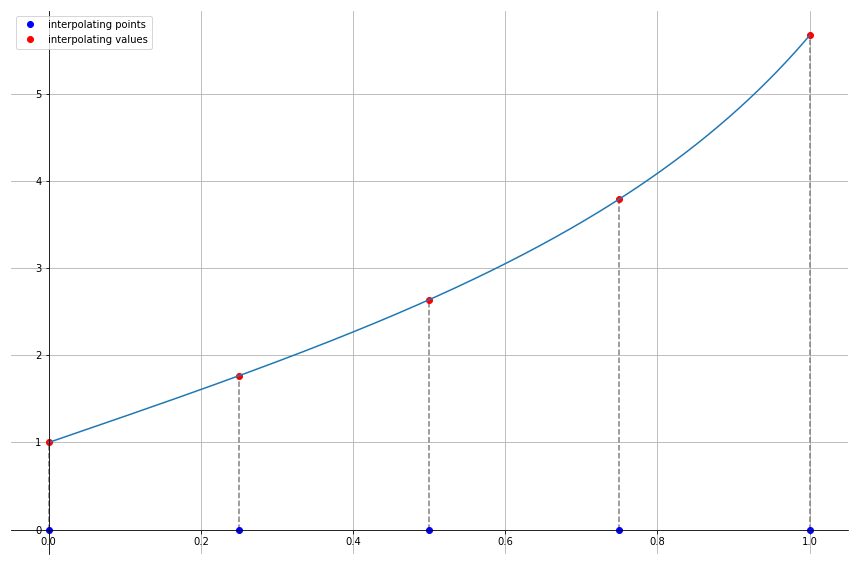

In [11]:
plot_interpolation()

## "Canonical" polynomial interpolation

With the canonical polynomial interpolation we want to find the coefficients $a = (a_0, a_1, \dots, a_n)^T$ to apply to the so called Vandermonde matrix $V$, made of the canonical polynomial basis $p = (1, x, x^2, \dots, x^n)$ applied on each of the interpolation points, to interpolate the values $y_{interpolation} = \{y_0, y_1, \dots, y_n\} = \{f(x_0), f(x_1), \dots, f(x_n)\}$ .

The matrix $V$ is: $$V=\begin{bmatrix}
                            1 & x_0 & x_0^2 & \dots & x_0^n\\
                            1 & x_1 & x_1^2 & \dots & x_1^n\\
                            \vdots & \vdots & \vdots & \ddots &\vdots \\
                            1 & x_n & x_n^2 & \dots & x_n^n
                        \end{bmatrix}$$

The linear system to solve is: $V a = y$ .

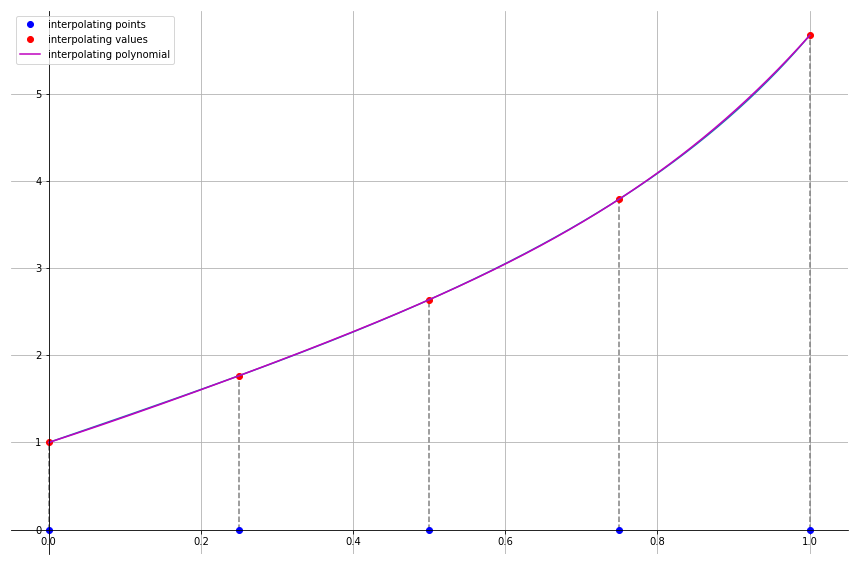

In [42]:
V = np.vander(x, increasing=True)

a = np.linalg.solve(V, y)[::-1]

p = np.poly1d(a)

plot_interpolation(polynomial=p)

## Lagrange polynomial interpolation

There's a problem when using the canonical polynomial interpolation: if we increase the number of points to interpolate, the error, which is the "distance" between the polynomial that interpolates and the real function beneath, increases as the power of $n$.

Technically, $V$ is said to be ill-conditioned and (also with a small $n$) $\implies a \neq a^*$ (where $a^*$ stands for the optimal coefficients vector, that produces no errors when the approximation and the real function are compared); to measure how much a linear system in the form $A\, x = b$ is ill-conditioned, the condition number $K(A) = ||A|| \; ||A^{-1}||$ is used.

<br>

Instead of using canonical polynomials as the basis of our approximation function, we can construct different polynomials which behave better with an increasing number of points. The specific interpolation representation we're going to use is the Lagrange polynomial interpolation. A basis for the polynomial space can be calculated with:

$$ l_i(x) := \prod\limits_{j=0, j \neq i}\limits^{n} \frac{x - x_j}{x_i - x_j} \quad \text{ with } i = 0, \dots, n $$

We need to construct the matrix $L$, the basis of the polynomial space $\Pi^{\;\!n}$, by applying the formula above on the tabulation vector, the space $[a, b]$ we are studying.

In [12]:
L = np.empty((number_of_points, verification_step))
for i, x_i in enumerate(x):
    L[i] = np.product([(tabulation_vector - x_j)/(x_i - x_j) for j, x_j in enumerate(x) if i != j], axis=0)

We want to obtain a polynomial $P_n(x)$ such that:
$$ P_n(x) = \sum\limits_{i=0}\limits^{n} b_i l_i (x) $$

And we want that the value of the polynomial in the interpolating points matches the value $y_j$ of the function $f$ in the point $x_j$:
$$P_n(x_j) = \sum_{i=0}^{n} b_i l_i (x_j) = b_j = y_j $$
since $ l_i (x_j)$ is the Kronecker delta $\delta_{ij}$.

Now the polynomial that approximates $f$ can be constructed by multiplying the Lagrange basis with the value of the function in the interpolating points.

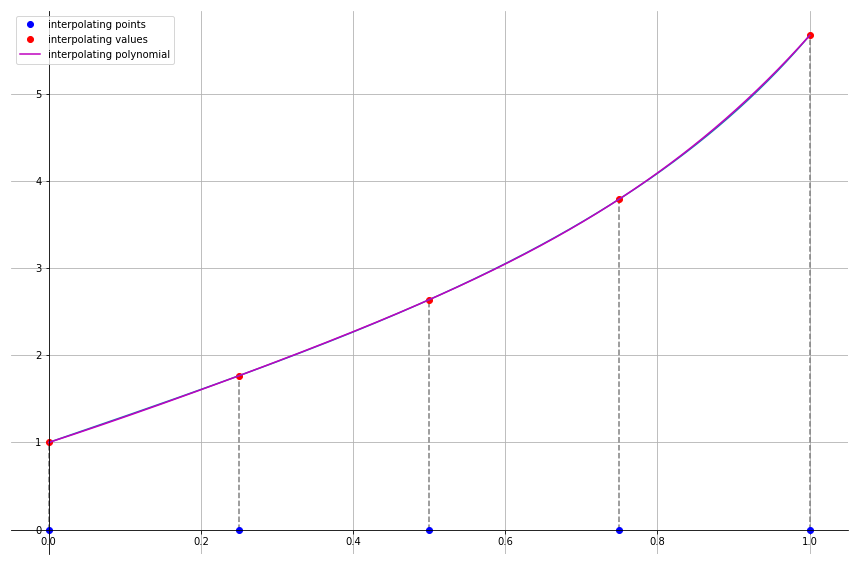

In [40]:
values_at_interpolating_points = L.T.dot(y)

plot_interpolation(tabulated_values=values_at_interpolating_points)

## Newton representation

Let $f[x_0] = f(x_0)$ and $$f[x_0, x] = \frac{f(x) - f(x_0)}{x - x_0} = \frac{f[x] - f[x_0]}{x - x_0}$$

$$f[x_0, \dots, x_n, x] = \frac{\overbrace{f[x_1, \dots, x_n, x]}^\text{last n+1} - \overbrace{f[x_0, \dots, x_n]}^\text{first n+1}}{x - x_0}$$

For $k + 1$ data points we construct the Newton basis as


$$ n_j(x) := \prod_{i=0}^{j-1} (x - x_i) \qquad j=0,\ldots,k $$

Using these polynomials as a basis for $\Pi_k$ we have to solve

$$\begin{bmatrix}
      1 &         & \ldots &        & 0  \\
      1 & x_1-x_0 &        &        &    \\
      1 & x_2-x_0 & (x_2-x_0)(x_2-x_1) &        & \vdots   \\
 \vdots & \vdots  &        & \ddots &    \\
      1 & x_k-x_0 & \ldots & \ldots & \prod_{j=0}^{k-1}(x_k - x_j)
\end{bmatrix}
\begin{bmatrix}     a_0 \\     \\     \vdots \\     \\     a_{k} \end{bmatrix} =
\begin{bmatrix}      y_0 \\  \\  \vdots \\ \\    y_{k} \end{bmatrix}$$

to solve the polynomial interpolation problem.

[//]: # (
This system of equations can be solved iteratively by solving
$$\sum_{i=0}^{j} a_{i} n_{i}(x_j) = y_j \qquad j = 0,\dots,k$$
)

In [129]:
N_mat = np.zeros((number_of_points, number_of_points))
N_mat[:, 0] = 1.

for x_i_idx, x_i in enumerate(x):
    for x_j_idx in range(1, x_i_idx+1):
        x_j_1 = x[x_j_idx-1]
        N_mat[x_i_idx, x_j_idx] = (x_i - x_j_1) * N_mat[x_i_idx, x_j_idx-1]

N_mat

array([[1.     , 0.     , 0.     , 0.     , 0.     ],
       [1.     , 0.25   , 0.     , 0.     , 0.     ],
       [1.     , 0.5    , 0.125  , 0.     , 0.     ],
       [1.     , 0.75   , 0.375  , 0.09375, 0.     ],
       [1.     , 1.     , 0.75   , 0.375  , 0.09375]])

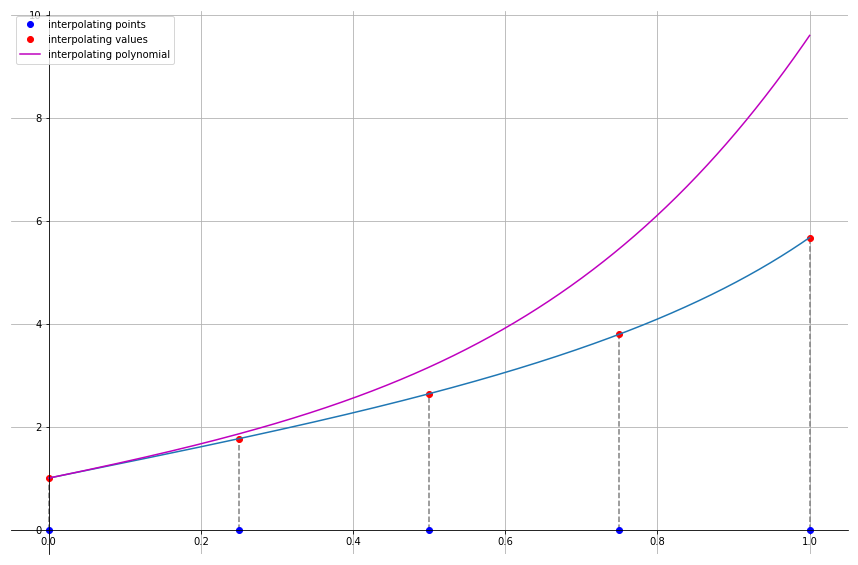

In [132]:
a = np.linalg.solve(N_mat, y)[::-1]

p = np.poly1d(a)

plot_interpolation(polynomial=p)